<b>Simon Algorithm </b>

In this algorithm we are going to introduce and develop Simon Algorithm on Qiskit. Simon Algorithm is a quantum algorithm that, given a function f(x) that has two different types of mapping:  
  
  - One-to-one: for every input value x, there is one different value output (example: f(1) = 1 or f(2) = 2)  
  - Two-to-one: for every 2 input value x, there is one different value output (example: f(1) = f(2) = 0 but f(3) = f(4) = 1)  
  
And this Two-to-one mapping works according to:  
$\textrm{given }x_1,x_2: \quad f(x_1) = f(x_2) \\
\textrm{it is guaranteed }: \quad x_1 \oplus x_2 = b$  
  
So this algorithm wants to guess the type of f(x), if it's one-to-one or two-to-one mapping, and in case is two-to-one, it will also guess the secret bitstring b. We already know that, for one-to-one mapping, secret bitstring b = 000..., and for two-to-one mapping, secret bitstring b will be the rest of possible values.

<b>Classical solution</b> needs to query the oracle of the function f(x) half of all possible inputs until we find two cases with the same input (we would see that f(x) is two-to-one mapping). So, at worst case, when we are really unlucky to have two-to-one mapping, but we find two cases with the same input at last case, we would have executed the oracle half of all possible inputs times (2^n-1 + 1).

<b>Quantum solution</b> aims to reduce this complexity as much as possible, so that we would need to query the oracle only 1 time to guess the type of f(x), taking advantage of the paralellism that gives us the quantum computation. The quantum circuit to solve this algorithm is this circuit:  
  
<img src="https://qiskit.org/textbook/ch-algorithms/images/simon_steps.png">  
  
As we saw in the previous algorithms, all of them start with Hadamart gates to get the superposition of all qubits and keep all of them in mind for the oracle.  
  
Then, the query function will act on all qubits and it will depend on the function f(x) we want to test, but the generic behavior is:  
  
$\lvert x \rangle \lvert a \rangle \rightarrow \lvert x \rangle \lvert a \oplus f(x) \rangle$
  
And, finally, we will measure first the second register before we apply Hadamart gates on the first register and measure it afterwards.  
  
The value we can observe from first register, because of the setting of the problem, could correspond to two possible inputs: x and y=x⊕b. And, if we observe the second register, we can find an output only if $(-1)^{x \cdot z} = (-1)^{y \cdot z}$, so a string z will be measured, and repeating the algorithm n times, we will find different n values from string z, and the following system can be written to solve for b:  
  
$\begin{cases} b \cdot z_1 = 0 \\ b \cdot z_2 = 0 \\ \quad \vdots \\ b \cdot z_n = 0 \end{cases}$

Now we will do an example with secret string b = 11 and y = x ⊕ b, so that f(x) = f(y). Note that this function f(x) will be a two-to-one mapping. The quantum circuit to solve the problem is:  
  
<img src="https://qiskit.org/textbook/ch-algorithms/images/simon_example.png">  
  
Here, the most important thing to know is the oracle we will create. Because b = 11, we will put CNOT in all qubits, but if b has one bit with value 0, CNOT's that belong to that bit can be omitted.

And now, we will implement the algorithm on a circuit, and we will execute it to see the results.

In [1]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
import numpy as np

We will build a circuit with 3 qubits on each register, to have a secret string b of size 3. In our example, b = 110

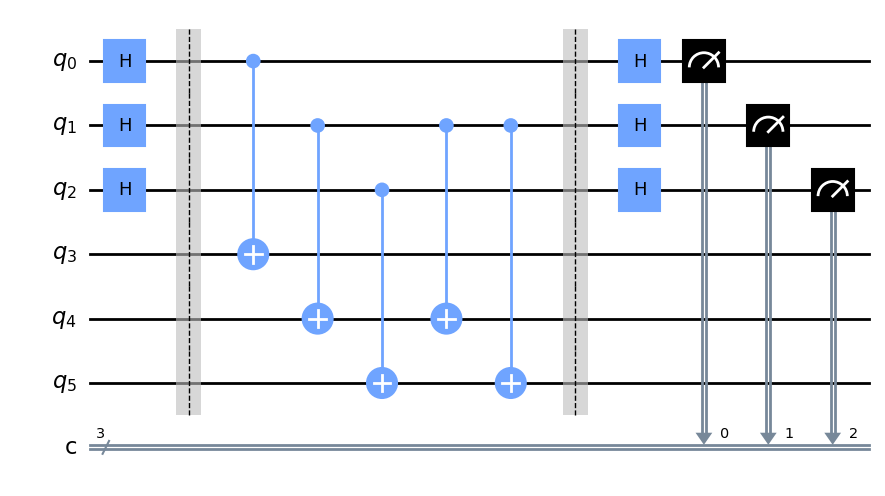

In [5]:
algorithm = QuantumCircuit(6, 3)

algorithm.h([0,1,2])
algorithm.barrier()

algorithm.cx(0,3)
algorithm.cx(1,4)
algorithm.cx(2,5)
algorithm.cx(1,4)
algorithm.cx(1,5)
algorithm.barrier()

algorithm.h([0,1,2])
algorithm.measure([0,1,2], [0,1,2])

algorithm.draw(output='mpl')

And now we will execute the circuit:

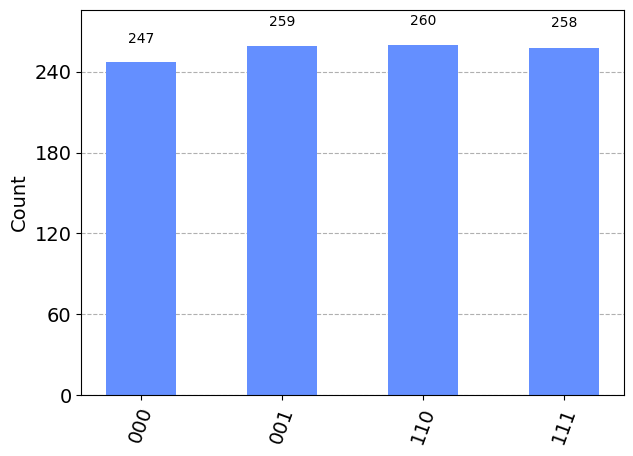

In [6]:
simulator = Aer.get_backend('aer_simulator')
qobj = assemble(algorithm)
histogram = simulator.run(qobj).result().get_counts()
plot_histogram(histogram)

We get the same probability, approx, on some different z values. Now we will build the equation system to solve it for b, but first we will verify if the results satisfy $b\cdot z  = 0 \pmod{2}$ :  
  
110.000 = 0 (mod 2)  
110.110 = 0 (mod 2)  
110.001 = 0 (mod 2)  
110.111 = 0 (mod 2)  
  
Then, we can build the system by saying that, for example, we first measured 001:  
  
$\begin{aligned}
b \cdot 001 &= 0 \\
(b_2 \cdot 0) + (b_1 \cdot 0) + (b_0 \cdot 1) & = 0 \\
(\cancel{b_2 \cdot 0}) + (\cancel{b_1 \cdot 0}) + (b_0 \cdot 1) & = 0 \\
b_0 & = 0\\
\end{aligned}$  
  
We can see that b2 and b1 are cancelled because of that 0, so we will suppose we next measure 111. Then, we have this system:  
  
$\begin{aligned}
b \cdot 111 &= 0 \\
(b_2 \cdot 1) + (b_1 \cdot 1) + (\cancel{0 \cdot 1}) & = 0 \\
(b_2 \cdot 1) + (b_1 \cdot 1) & = 0 \\
\end{aligned}$  
  
Which tells us that b can be 000 or 110, because $b_2 = b_1 = 1$ or $b_2 = b_1 = 0$, but b_0 is always 0. We can solve this system and find the non-trivial solution (that we know that is 110 because we have built the problem) using Gaussian elimination algorithm.